In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

/tmp/ipykernel_3245379/2477651863.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Conda Environment: tf_env


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

import scipy.io
import scipy.interpolate

import sklearn

from tqdm.notebook import tqdm

import copy
import time
import gc

In [3]:
import sys
# sys.path.append('/n/data1/hms/neurobio/sabatini/rich/github_repos/')
sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

%load_ext autoreload
%autoreload 2
from NBAP import import_data, align_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from pathlib import Path

# dir_S2p             = Path(r'/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210409/baseline/suite2p/plane0/')
dir_S2p             = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/suite2p/plane0')

# dir_ROIClassifier   = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210418/analysis_lastNight')

dir_ws              = Path(r'/media/rich/bigSSD/res2p/wavesurfer data/round 5 experiments/mouse 2_6/20210417')
fileName_ws         = Path(r'exp_0001.h5')

dir_cameraCSV       = Path(r'/media/rich/bigSSD/res2p/Camera data/round 5 experiments/mouse 2_6/20210417/cam3/experiment')
fileName_cameraCSV  = Path(r'times_cam32021-04-18T00_41_02.csv')

# dir_faceRhythm      = Path(r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run1_vqt/data')
# fileName_faceRhythm = Path('factors_spectral_temporal_interp2.npy')

In [5]:
F , Fneu , iscell , ops , spks , stat , num_frames_S2p = import_data.import_S2p(dir_S2p)

# IsCell_ROIClassifier , ROI_Classifier_manual_selection_vars = import_data.import_roiClassifier(dir_ROIClassifier)

ws_data = import_data.import_ws(dir_ws / fileName_ws)

cameraCSV , signal_GPIO = import_data.import_cameraCSV(dir_cameraCSV / fileName_cameraCSV)

# temporalFactors_faceRhythm = import_data.import_temporalFactorsFR(dir_faceRhythm / fileName_faceRhythm)

## Make alignment templates

### make CAMERA alignment template

convert the absolute times into relative seconds

In [6]:
cameraTimes = align_data.convert_camTimeDates_toAbsoluteSeconds(cameraCSV[:,3])

extract pulses from GPIO

In [7]:
sig_camTimes__idx_cam = cameraTimes
sig_pulses__idx_cam = np.diff(np.int8(np.diff(signal_GPIO, prepend=np.nan) > 1), prepend=np.nan) > 0.5

sig_camTimes__idx_pulses = cameraTimes[sig_pulses__idx_cam]

make template as times relative to the interval between the first and last pulse (rising edge)

In [8]:
sig_camTimesAligned__idx_cam = (cameraTimes - sig_camTimes__idx_pulses[0]) / (sig_camTimes__idx_pulses[-1] - sig_camTimes__idx_pulses[0])

### make WAVESURFER and SCANIMAGE templates

extract SI frame times from recorded flybacks on WS \
AND extract pulse times recorded on WS

In [9]:
ws_galvoFlyBackTrace = ws_data[6]
ws_pulseTrace = ws_data[0]

sig_SIFlybacks__idx_ws = np.diff(np.int8(np.diff(ws_galvoFlyBackTrace, prepend=np.nan) < -1), prepend=np.nan) > 0.5
sig_pulses__idx_ws = np.diff(np.int8(np.diff(ws_pulseTrace, prepend=np.nan) > 1), prepend=np.nan) > 0.5

sig_wsIdx__idx_SIFlybacks = np.where(sig_SIFlybacks__idx_ws)[0]
sig_wsIdx__idx_pulses = np.where(sig_pulses__idx_ws)[0]

make templates as times relative to the interval between the first and last pulse (rising edge)

In [10]:
sig_wsTimesAligned__idx_ws = (np.arange(len(ws_data[0])) - sig_wsIdx__idx_pulses[0]) / (sig_wsIdx__idx_pulses[-1] - sig_wsIdx__idx_pulses[0])
sig_SITimesAligned__idx_SI = (sig_wsIdx__idx_SIFlybacks - sig_wsIdx__idx_pulses[0]) / (sig_wsIdx__idx_pulses[-1] - sig_wsIdx__idx_pulses[0])

store outputs

In [11]:
aligned_trace_times = {'camera': sig_camTimesAligned__idx_cam,
                       'waveSurfer': sig_wsTimesAligned__idx_ws,
                       'scanImage': sig_SITimesAligned__idx_SI}

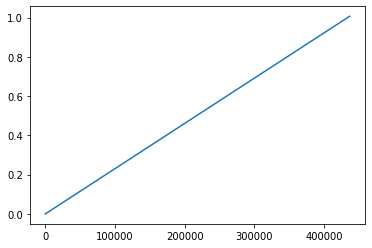

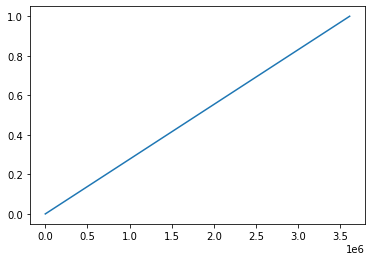

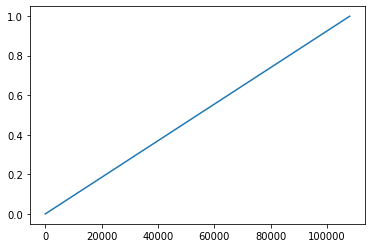

In [12]:
for key,trace in aligned_trace_times.items():
    plt.figure()
    plt.plot(trace)

## Perform alignment
align wavesurfer traces into SI times

In [13]:
len_SI = aligned_trace_times['scanImage'].shape[0]
k_width = int(ws_data.shape[1] / len_SI)
k_halfWidth = np.ceil(k_width/2)+2
kernel = np.concatenate((np.arange(1,k_halfWidth+1,1), np.array([k_halfWidth+1]), np.arange(k_halfWidth,0, -1)))
kernel = kernel / kernel.sum()

In [15]:
licksBool = np.diff(np.diff(ws_data[3], prepend=0) < -1, prepend=0) > 0.5
licksBool_conv = np.convolve(licksBool, kernel, mode='same')
sig_wsLicks__idx_SI_raw = scipy.interpolate.interp1d(x=aligned_trace_times['waveSurfer'],
                                                 y=licksBool_conv,
                                                 kind='linear')(aligned_trace_times['scanImage'])
peaks = scipy.signal.find_peaks(sig_wsLicks__idx_SI_raw)[0]
sig_wsLicks__idx_SI = indexing.idx2bool(peaks, length=len_SI)

rewardsBool = np.diff(np.diff(ws_data[4], prepend=0) > 1, prepend=0) > 0.5
rewardsBool_conv = np.convolve(rewardsBool, kernel, mode='same')
sig_wsRewards__idx_SI_raw = scipy.interpolate.interp1d(x=aligned_trace_times['waveSurfer'],
                                                 y=rewardsBool_conv,
                                                 kind='linear')(aligned_trace_times['scanImage'])
peaks = scipy.signal.find_peaks(sig_wsRewards__idx_SI_raw)[0]
sig_wsRewards__idx_SI = indexing.idx2bool(peaks, length=len_SI)

sig_wsTreadmill__idx_SI = scipy.interpolate.interp1d(x=aligned_trace_times['waveSurfer'],
                                                 y=ws_data[2],
                                                 kind='linear')(aligned_trace_times['scanImage'])

sig_wsCursor__idx_SI = scipy.interpolate.interp1d(x=aligned_trace_times['waveSurfer'],
                                                 y=ws_data[5],
                                                 kind='linear')(aligned_trace_times['scanImage'])

store outputs

In [18]:
wsTraces_aligned_to_SI = pd.DataFrame(
    {
        'licks': sig_wsLicks__idx_SI,
        'rewards': sig_wsRewards__idx_SI,
        'treadmill': sig_wsTreadmill__idx_SI,
        'cursor': sig_wsCursor__idx_SI
    }
)

<IPython.core.display.Javascript object>


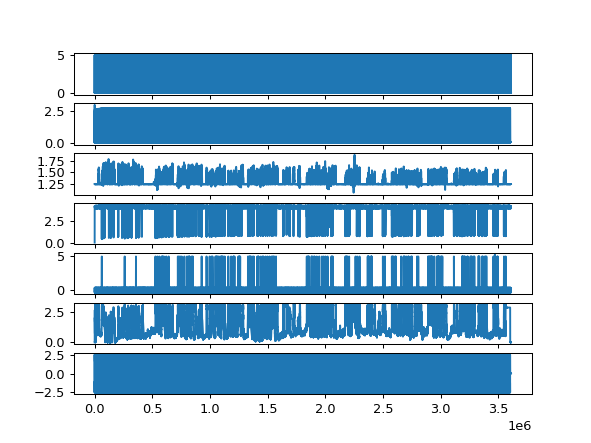

In [19]:
%matplotlib notebook
fig, axs = plt.subplots(ws_data.shape[0], sharex=True)
for ii,ax in enumerate(axs):
    ax.plot(ws_data[ii])

### Save outputs

In [20]:
pickle_helpers.simple_save(
    obj=wsTraces_aligned_to_SI,
    filename=r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/BMI_IDAP_run/wsTraces_aligned_to_SI__DF.pkl',
)

# Convert logger file to a pandas dataframe h5 file

In [21]:
import pandas as pd
import scipy.io

In [22]:
logger_aligned = scipy.io.loadmat(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/logger_aligned.mat', simplify_cells=True)['logger_aligned']
expParams = scipy.io.loadmat(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/expParams.mat', simplify_cells=True)['expParams']

### Check the alignment of WS and the logger

<IPython.core.display.Javascript object>


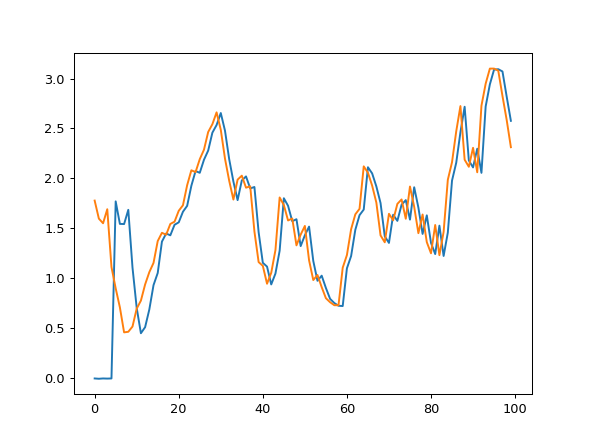

In [24]:
plt.figure()
plt.plot(np.array(sig_wsCursor__idx_SI[:100]))
plt.plot(np.array(logger_aligned['decoder'][:,4][:100]))

### offset the logger
typically, the logger is lagged by 1 frame because the way I start the BMI software is dumb and causes it to be lagged by 1 frame.

In [25]:
shift = 1

logger_aligned_shifted = {
    key: indexing.shift_pad(
        array=array,
        shift=shift,
        axis=0,
        pad_val=np.nan,
        in_place=False,
    ) for key,array in logger_aligned.items()
}


In [26]:
logger_aligned_df = {
    key: pd.DataFrame(
        data=array,
        columns=expParams['loggerNames'][key],
    ) for key,array in logger_aligned_shifted.items()
}

def remove_duplicate_DataFrame_columns(df):
    return df.loc[:,~df.columns.duplicated()]

logger_aligned_df_noDup = { key: remove_duplicate_DataFrame_columns(array) for key,array in logger_aligned_df.items() }

<IPython.core.display.Javascript object>


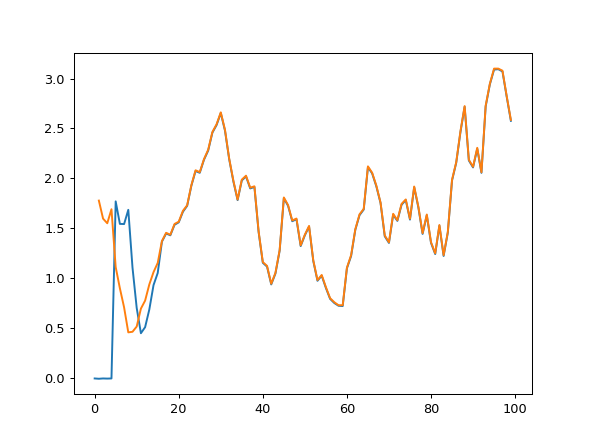

In [28]:
plt.figure()
plt.plot(sig_wsCursor__idx_SI[:100])
plt.plot(logger_aligned_df_noDup['decoder']['voltage_cursorCurrentPos'][:100])

### Save logger

In [29]:
pickle_helpers.save_dict(logger_aligned_df_noDup, r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/BMI_IDAP_run/logger_aligned__DF.pkl')

In [ ]:
import sys
# sys.path.append('/n/data1/hms/neurobio/sabatini/rich/github_repos/')
sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

In [4]:
import pickle

def pickle_load(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

from pathlib import Path

directory = r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/BMI_IDAP_run/'

path_spks = Path(directory).resolve() / r'spks_cas.npy'
spks = np.load(path_spks)

path_logger = Path(directory).resolve() / r'logger_aligned__DF.pkl'
logger = pickle_load(path_logger)

path_ws = Path(directory).resolve() / r'wsTraces_aligned_to_SI__DF.pkl'
ws = pickle_load(path_ws)

<IPython.core.display.Javascript object>


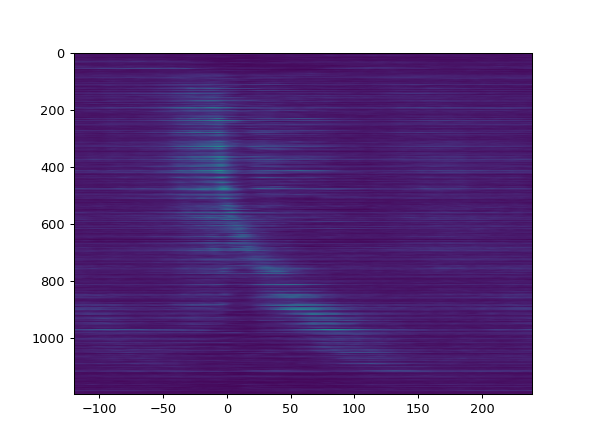

In [129]:
timeSeries.make_sorted_event_triggered_average(
    arr=spks,
    trigger_signal=ws['rewards'].to_numpy(),
    win_bounds=[-30*4, 30*8],
    show_plot=True
);

In [87]:
def display_clustering_widget(
    embeddings, 
    min_samples, 
    max_samples=None,
    min_slider=0.01,
    max_slider=5, 
    start_slider=1.0,
    single_color=False,
    ):

    from ipywidgets import interact, widgets
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    sc = ax.scatter(embeddings[:,0], embeddings[:,1], s=15)
    # sc = ax.scatter(embeddings2[:,0], embeddings2[:,1], embeddings2[:,2], s=15)

    def get_val_counts(vals):
        vals_unique = np.unique(vals)
        vals_counts = np.zeros_like(vals, dtype=np.int64)
        for ii, val in enumerate(vals_unique):
            vals_counts[vals==val] = np.sum(vals==val)
        return vals_counts
    def update(eps = 1.0):
        eps_toUse = (eps/200)**2
        # Compute DBSCAN
        db = sklearn.cluster.DBSCAN(
            eps=eps_toUse,
            min_samples=min_samples, 
    #         metric='manhattan',
            metric_params=None, 
            algorithm='auto',
            leaf_size=30, 
            p=2, 
            n_jobs=-1
        ).fit(embeddings)
        print(eps_toUse)

        labels = db.labels_
    #     labels = db.labels_ - db.labels_.min()
        if max_samples is not None:
            labels[get_val_counts(labels) > max_samples] = -1

        if single_color:
            cmap = rand_cmap(2, verbose=False)
        else:
            cmap = rand_cmap(len(np.unique(labels)), verbose=False)

        if len(np.unique(labels)) == 1:
            print('Eps value gives one big cluster. Adjust')
        else:
            sc.set_color(cmap(squeeze_integers(labels)+1))

            fig.canvas.draw_idle()
            ax.set_title(f'eps={round(eps_toUse,2)}, n_clusters={len(np.unique(labels))}')
            print(np.unique(labels))

    interact(update, eps=widgets.IntSlider(min=np.sqrt(min_slider)*200, max=np.sqrt(max_slider)*200, step=1, value=np.sqrt(start_slider)*200));

In [90]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft', 'random'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

#     # Generate color map for bright colors, based on hsv
#     if type == 'bright':
#         randHSVcolors = [(np.random.uniform(low=0.0, high=1),
#                           np.random.uniform(low=0.2, high=1),
# #                           np.random.uniform(low=0.9, high=1)) for i in xrange(nlabels)]
#                           np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

#         # Convert HSV list to RGB
#         randRGBcolors = []
#         for HSVcolor in randHSVcolors:
#             randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

    randRGBcolors = np.random.rand(nlabels, 3)
    if type == 'bright':
        randRGBcolors = randRGBcolors / np.max(randRGBcolors, axis=1, keepdims=True)

    if first_color_black:
        randRGBcolors[0] = [0, 0, 0]

    if last_color_black:
        randRGBcolors[-1] = [0, 0, 0]

    random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
#                           np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        fig, ax = plt.subplots(1, 1, figsize=(6, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap


def squeeze_integers(intVec):
    """
    Make integers in an array consecutive numbers
     starting from 0. ie. [7,2,7,4,1] -> [3,2,3,1,0].
    Useful for removing unused class IDs from y_true
     and outputting something appropriate for softmax.
    This is v2. The old version is busted.
    RH 2021
    
    Args:
        intVec (np.ndarray):
            1-D array of integers.
    
    Returns:
        intVec_squeezed (np.ndarray):
            1-D array of integers with consecutive numbers
    """
    uniques = np.unique(intVec)
    # unique_positions = np.arange(len(uniques))
    unique_positions = np.arange(uniques.min(), uniques.max()+1)
    return unique_positions[np.array([np.where(intVec[ii]==uniques)[0] for ii in range(len(intVec))]).squeeze()]


In [100]:
import umap

umap = umap.umap_.UMAP(
    n_neighbors=5,
    n_components=2, 
    metric='euclidean',
    metric_kwds=None, 
    output_metric='euclidean', 
    output_metric_kwds=None,
    n_epochs=None, 
    learning_rate=1.0, 
    init='spectral',
    min_dist=0.1, 
    spread=1.0, 
    low_memory=True,
    n_jobs=-1, 
    set_op_mix_ratio=1.0, 
    local_connectivity=1.0, 
    repulsion_strength=1.0, 
    negative_sample_rate=5, 
    transform_queue_size=4.0,
    a=None, 
    b=None, 
    random_state=None, 
    angular_rp_forest=False, 
    target_n_neighbors=-1, 
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding', 
    force_approximation_algorithm=False, 
    verbose=False,
    tqdm_kwds=None, 
    unique=False,
    densmap=False, 
    dens_lambda=2.0, 
    dens_frac=0.3, 
    dens_var_shift=0.1, 
    output_dens=False, 
    disconnection_distance=None, 
    precomputed_knn=(None, None, None)
)

In [106]:
spks_z = scipy.stats.zscore(spks, axis=1)

In [107]:
test = umap.fit_transform(spks_z)

<IPython.core.display.Javascript object>


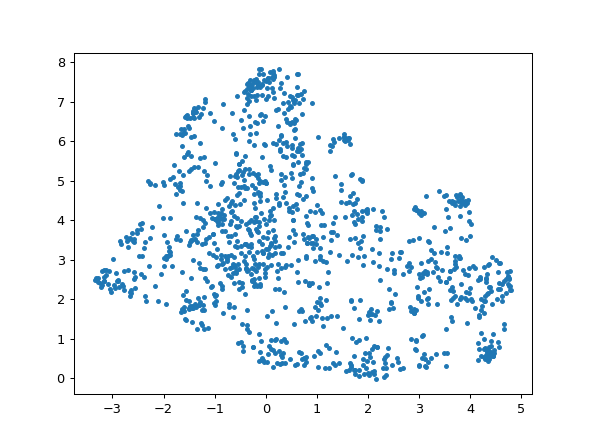

In [109]:
%matplotlib notebook

plt.figure()
plt.scatter(test[:,0], test[:,1], s=8)

In [110]:
embeddings = test

<IPython.core.display.Javascript object>


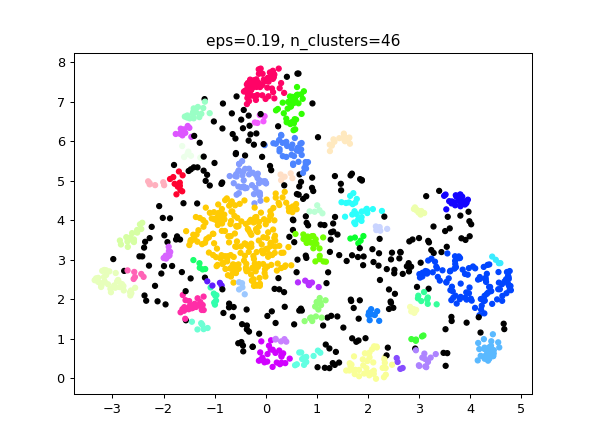

interactive(children=(IntSlider(value=200, description='eps', max=200, min=20), Output()), _dom_classes=('widg…

In [111]:
%matplotlib notebook

# block_toUse = 40
min_samples = 5
max_samples = 2000 # for use within this cell only (visualization and titrating eps value). Set to None to speed up visualization

# embeddings = block_rois_raw[block_toUse]['embeddings']
    
display_clustering_widget(embeddings, min_samples, max_samples=max_samples, min_slider=0.01, max_slider=1, start_slider=1.0, single_color=False)

<IPython.core.display.Javascript object>


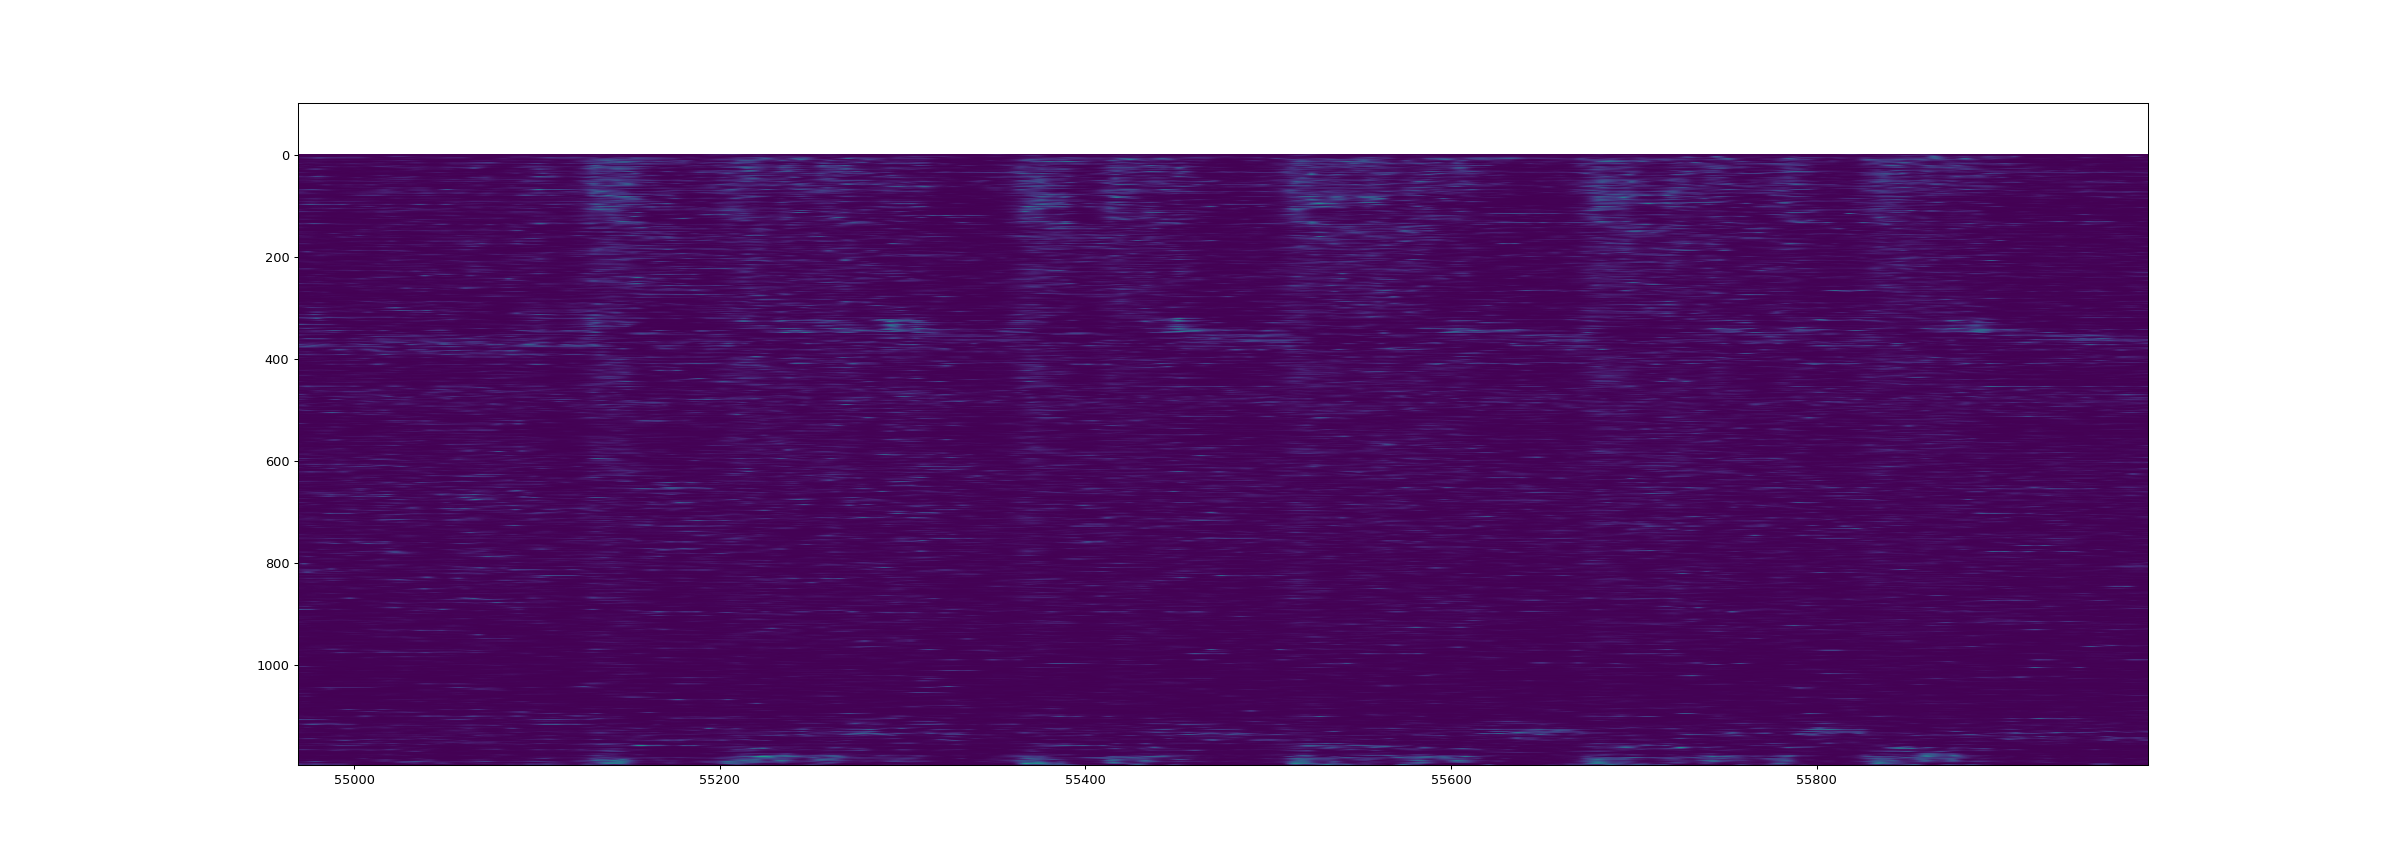

In [63]:
order = np.argsort(test[:,0])
plt.figure()
plt.imshow(spks[order], aspect='auto')

In [56]:
import rastermap

In [114]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [118]:
test3 = rmap.fit_transform(spks)

nmin 200
0.17848730087280273
5.894369125366211
6.2106709480285645
6.214856386184692
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.1513      2
0.10s    10        0.2497      4
0.24s    20        0.2956      8
0.37s    30        0.3418      18
0.43s    40        0.3681      28
0.55s    50        0.3949      38
0.63s    60        0.4011      38
0.71s   final      0.4012
0.71s upsampled    0.4012


<IPython.core.display.Javascript object>


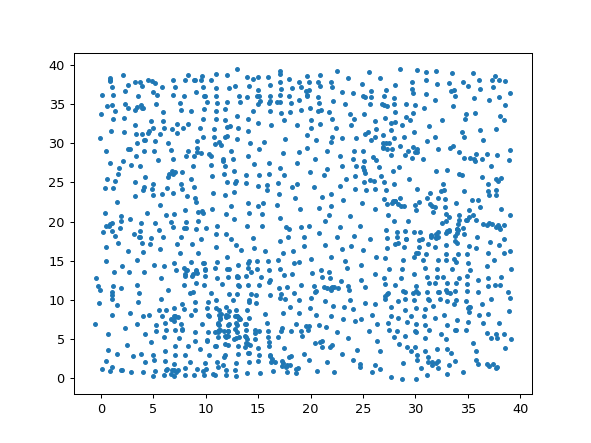

In [113]:
plt.figure()
plt.scatter(test3[:,0], test3[:,1], s=8)

<IPython.core.display.Javascript object>


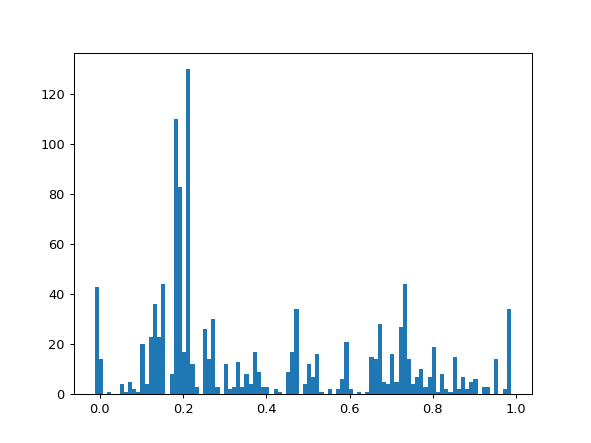

In [124]:
plt.figure()
plt.hist(test3, 100);

<IPython.core.display.Javascript object>


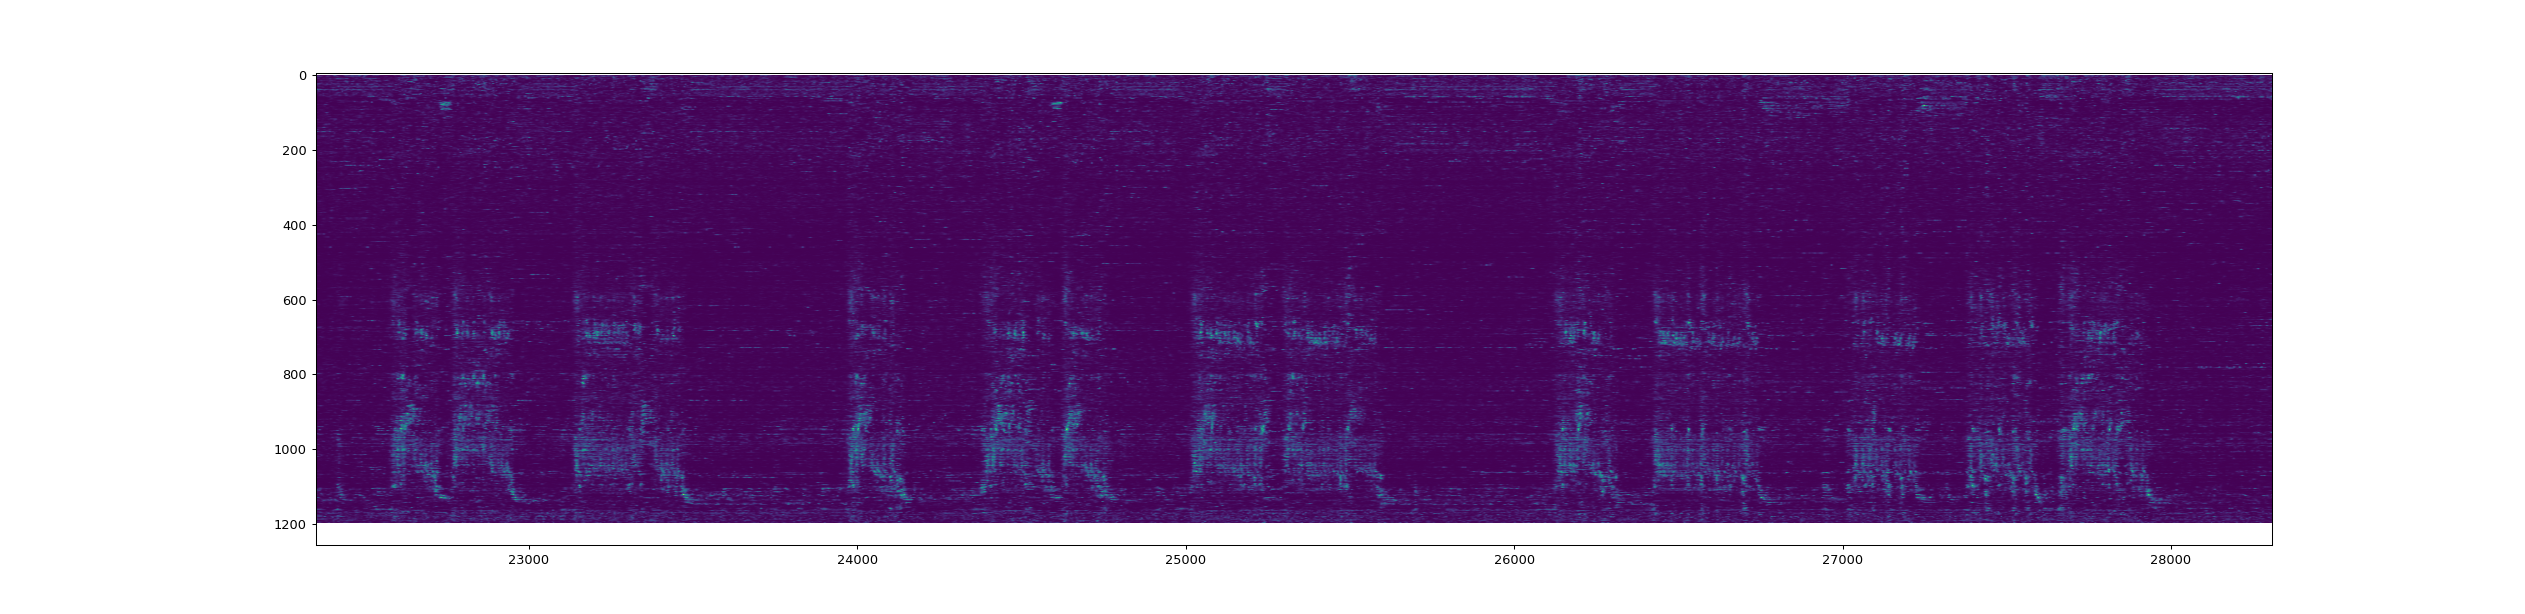

In [126]:
order = np.argsort(test3[:,0])
plt.figure()
plt.imshow(spks[order], aspect='auto', vmax=1)

<IPython.core.display.Javascript object>


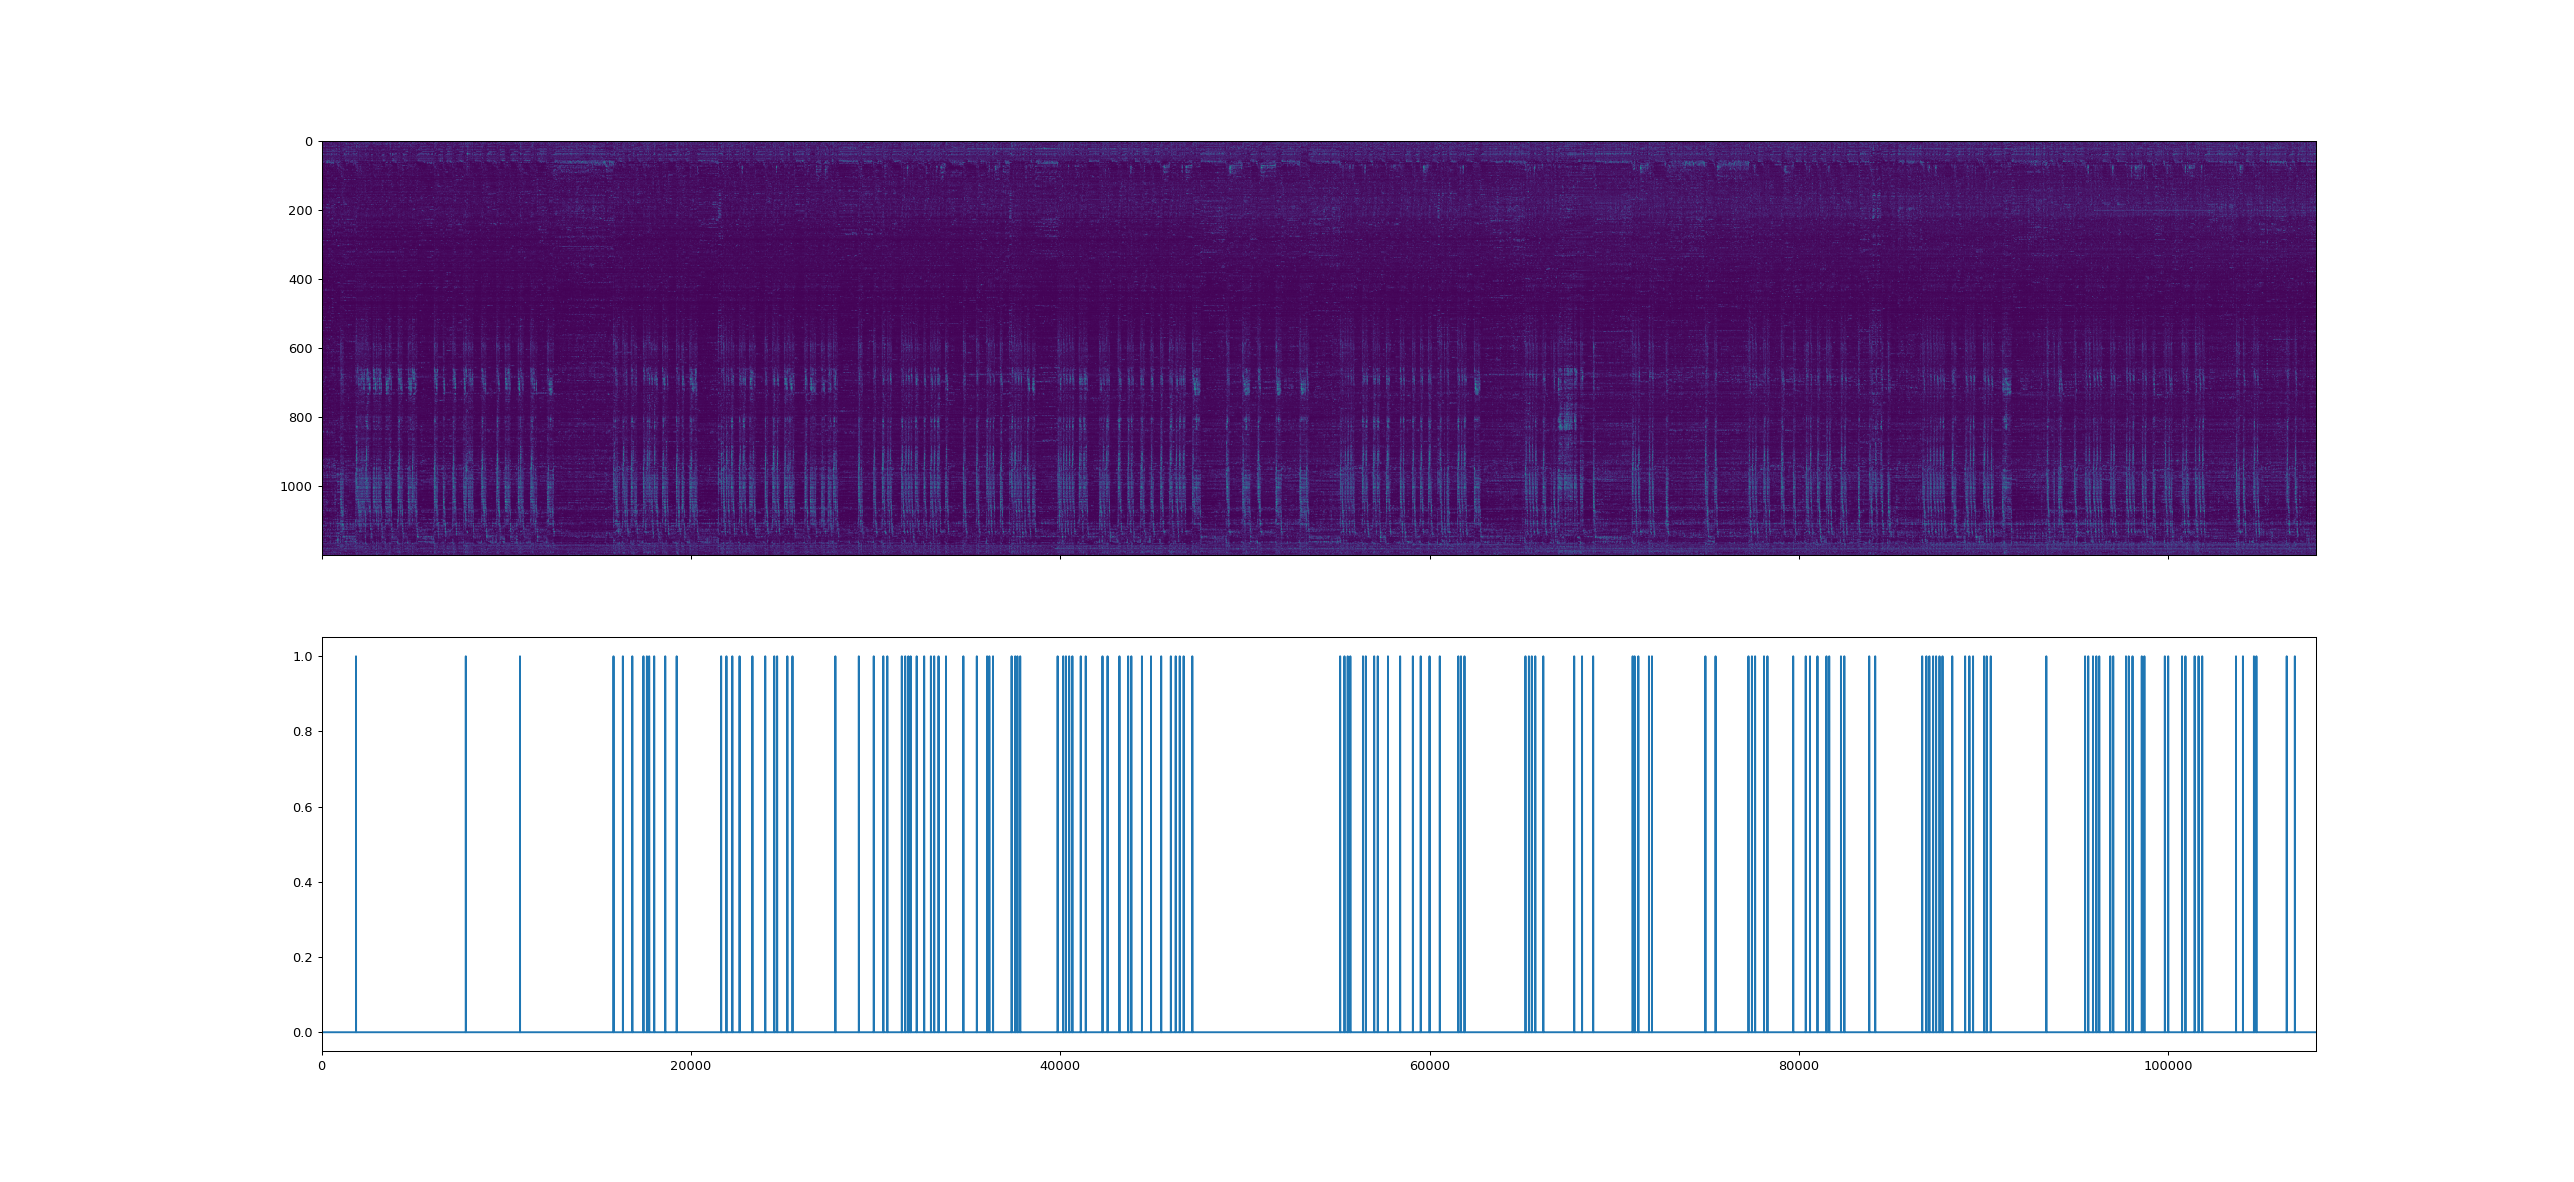

In [128]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].imshow(spks[order], aspect='auto', vmax=0.67)
axs[1].plot(ws['rewards'])